# Object Detection

In [1]:
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')
DRIVE_ROOT = Path('/content/drive/MyDrive/datasets')
MODEL_ROOT = Path('/content/drive/MyDrive/models')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%pip install -q matplotlib
%pip install -q torchviz torchinfo
%pip install -q tqdm

In [3]:
from IPython.display import display

import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tqdm.notebook import tqdm

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchinfo import summary
from torchvision import datasets, models, transforms

%matplotlib inline
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (3, 3)
plt.rcParams['axes.grid'] = True
np.set_printoptions(suppress=True, precision=4)

In [4]:
from pathlib import Path
import shutil

# Enable GPU device if available.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def copy_file(src, dst_dir, show_progress=True, chunk_size=100*(1024**2)):
    src = Path(src)
    dst = Path(dst_dir) / src.name
    os.makedirs(dst_dir, exist_ok=True)

    if not show_progress:
        shutil.copy2(src, dst)
        return

    print(f'Copy {src} to {dst}.')
    with src.open('rb') as src_file, dst.open('wb') as dst_file:
        total_size = src.stat().st_size
        with tqdm(total=total_size, desc="Copying", unit="MB", unit_scale=True) as progress_bar:
            while chunk := src_file.read(chunk_size):
                dst_file.write(chunk)
                progress_bar.update(len(chunk))

def train(model, criterion, optimizer, data_loader, device):
    n_data = 0
    total_loss = 0
    total_correct = 0

    model.train()
    for inputs, labels in tqdm(data_loader, desc='Train', leave=False):
        batch_size = len(labels)
        n_data += batch_size

        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        predicted = torch.max(outputs, 1)[1]
        total_loss += loss.item() * batch_size
        total_correct += (predicted == labels).sum().item()
    return total_loss/n_data, total_correct/n_data


@torch.no_grad()
def test(model, criterion, data_loader, device):
    n_data = 0
    total_loss = 0
    total_correct = 0

    model.eval()
    for inputs, labels in tqdm(data_loader, desc='Test', leave=False):
        batch_size = len(labels)
        n_data += batch_size

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        predicted = torch.max(outputs, 1)[1]
        total_loss += loss.item() * batch_size
        total_correct += (predicted == labels).sum().item()
    return total_loss/n_data, total_correct/n_data


def train_and_test(num_epochs, model, criterion, optimizer, train_loader, test_loader, device):
    train_history = []
    test_history = []
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, criterion, optimizer, train_loader, device)
        test_loss, test_acc = test(model, criterion, test_loader, device)

        train_history.append([epoch, train_loss, train_acc])
        test_history.append([epoch, test_loss, test_acc])
        print (f'Epoch [{epoch+1}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} test_loss: {test_loss:.5f}, test_acc: {test_acc:.5f}')

    return train_history, test_history

## Dataset
* [PASCAL Visual Object Classes Challenge 2012 (VOC2012)](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html)

In [5]:
CACHE = DRIVE_ROOT / 'VOCtrainval_11-May-2012.tar'
DATA_ROOT='./data/'

if CACHE.exists():
    copy_file(CACHE, DATA_ROOT)

Copy /content/drive/MyDrive/datasets/VOCtrainval_11-May-2012.tar to data/VOCtrainval_11-May-2012.tar.


Copying:   0%|          | 0.00/2.00G [00:00<?, ?MB/s]

Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data/


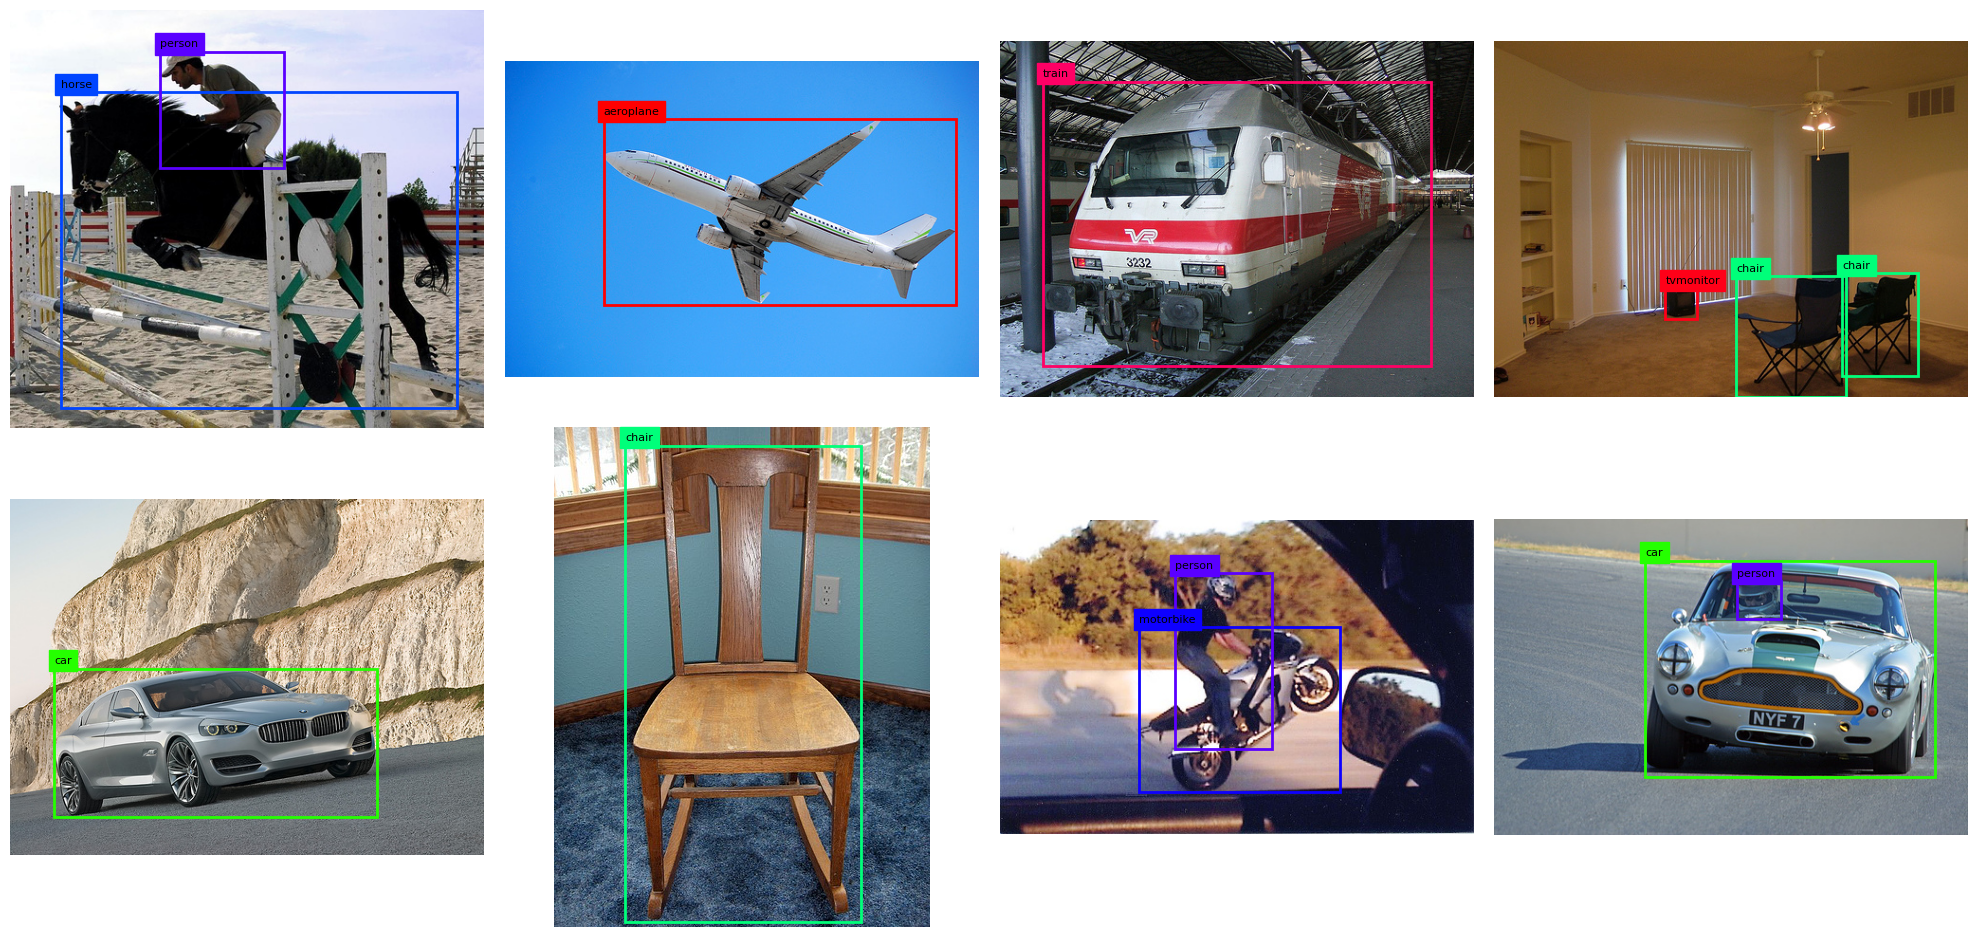

In [6]:
VOC_CLASSES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
    "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor",
]
VOC_CLASS_TO_INDEX = {
    class_name: index for index, class_name in enumerate(VOC_CLASSES)
}
CMAP = plt.cm.hsv(np.linspace(0, 1, len(VOC_CLASSES)))

def draw_annotation(ax, name, bbox):
    x, y, w, h = bbox
    color = CMAP[VOC_CLASS_TO_INDEX[name]]
    ax.text(x, y - 5, name, color='black', fontsize=8, backgroundcolor=color)
    rect = plt.Rectangle((x, y), w, h, edgecolor=color, facecolor='none', linewidth=2)
    ax.add_patch(rect)
    return ax

def target_transform(label):
    regions = []
    for region in label['annotation']['object']:
        name = region.get('name', None)
        bndbox = region['bndbox']
        x = int(bndbox['xmin'])
        y = int(bndbox['ymin'])
        w = int(bndbox['xmax']) - int(bndbox['xmin'])
        h = int(bndbox['ymax']) - int(bndbox['ymin'])
        regions.append((name, (x, y, w, h)))
    return regions


dataset = datasets.VOCDetection(root=DATA_ROOT, year="2012", image_set='train', download=True,
                                target_transform=target_transform)
subset = Subset(dataset, [0, 5, 9, 13, 14, 16, 32, 39])

N_COL = 4
N_ROW = math.ceil(len(subset) / N_COL)
fig, axes = plt.subplots(N_ROW, N_COL, figsize=(5*N_COL, 5*N_ROW))
for i, (image, targets) in enumerate(subset):
    r, c = divmod(i, N_COL)
    ax = axes[r, c]
    ax.axis('off')

    ax.imshow(image)
    for name, bbox in targets:
        draw_annotation(ax, name, bbox)

plt.tight_layout()
plt.show()

## R-CNN: Regions with CNN features
refference:<br>
[Girshick_Rich_Feature_Hierarchies_2014_CVPR_paper.pdf](https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Girshick_Rich_Feature_Hierarchies_2014_CVPR_paper.pdf)

Steps:
1. Input Image
2. Extract Region Proposals
3. Compute CNN Features
4. Classify Regions

#### Train VGG16 to adapt VOC2012 dataset

In [7]:
class VocClassificationDataset(Dataset):
    def __init__(self, root, image_set, download=True, transform=None):
        self.transform = transform
        dataset = datasets.VOCDetection(
            root=root, year='2012', image_set=image_set, download=download,
            target_transform=target_transform)

        self.images = []
        self.labels = []
        for image, label in dataset:
            for name, (x, y, w, h) in label:
                self.images.append(image.crop((x, y, x+w, y+h)))
                self.labels.append(VOC_CLASS_TO_INDEX[name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.images[idx]), self.labels[idx]
        else:
            return self.images[idx], self.labels[idx]

vgg16_transform = models.VGG16_Weights.DEFAULT.transforms()
train_dataset = VocClassificationDataset(root=DATA_ROOT, image_set='train', download=True,
                                         transform=vgg16_transform)
val_dataset = VocClassificationDataset(root=DATA_ROOT, image_set='val', download=True,
                                       transform=vgg16_transform)

Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data/
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data/


In [8]:
MODEL_PATH = MODEL_ROOT / "vgg16_voc_detection.pth"

def build_vgg16():
    model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
    n_fc_input = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(n_fc_input, len(VOC_CLASSES))
    return model

def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(path):
    model = build_vgg16()
    model.load_state_dict(torch.load(path))
    return model

In [9]:
BATCH_SIZE=256+128

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

vgg16 = build_vgg16()
vgg16 = vgg16.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr = 0.0001)

train_and_test(15, vgg16, criterion, optimizer, train_loader, val_loader, device);

Train:   0%|          | 0/42 [00:00<?, ?it/s]

Test:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [1/15], loss: 1.36780 acc: 0.60194 test_loss: 0.78891, test_acc: 0.76126


Train:   0%|          | 0/42 [00:00<?, ?it/s]

Test:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [2/15], loss: 0.64937 acc: 0.79853 test_loss: 0.70589, test_acc: 0.78419


Train:   0%|          | 0/42 [00:00<?, ?it/s]

Test:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [3/15], loss: 0.42556 acc: 0.86427 test_loss: 0.78644, test_acc: 0.77614


Train:   0%|          | 0/42 [00:00<?, ?it/s]

Test:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [4/15], loss: 0.28077 acc: 0.90858 test_loss: 0.88612, test_acc: 0.77887


Train:   0%|          | 0/42 [00:00<?, ?it/s]

Test:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [5/15], loss: 0.14763 acc: 0.95220 test_loss: 0.91792, test_acc: 0.78432


Train:   0%|          | 0/42 [00:00<?, ?it/s]

Test:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [6/15], loss: 0.11113 acc: 0.96291 test_loss: 0.98775, test_acc: 0.78419


Train:   0%|          | 0/42 [00:00<?, ?it/s]

Test:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [7/15], loss: 0.05769 acc: 0.98117 test_loss: 1.12768, test_acc: 0.78020


Train:   0%|          | 0/42 [00:00<?, ?it/s]

Test:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [8/15], loss: 0.04427 acc: 0.98643 test_loss: 1.27552, test_acc: 0.77893


Train:   0%|          | 0/42 [00:00<?, ?it/s]

Test:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [9/15], loss: 0.04189 acc: 0.98764 test_loss: 1.20368, test_acc: 0.76861


Train:   0%|          | 0/42 [00:00<?, ?it/s]

Test:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [10/15], loss: 0.06812 acc: 0.97965 test_loss: 1.17627, test_acc: 0.78634


Train:   0%|          | 0/42 [00:00<?, ?it/s]

Test:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [11/15], loss: 0.04315 acc: 0.98669 test_loss: 1.37069, test_acc: 0.76151


Train:   0%|          | 0/42 [00:00<?, ?it/s]

Test:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [12/15], loss: 0.04251 acc: 0.98751 test_loss: 1.19843, test_acc: 0.77589


Train:   0%|          | 0/42 [00:00<?, ?it/s]

Test:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [13/15], loss: 0.03185 acc: 0.99011 test_loss: 1.32492, test_acc: 0.77659


Train:   0%|          | 0/42 [00:00<?, ?it/s]

Test:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [14/15], loss: 0.01916 acc: 0.99372 test_loss: 1.28999, test_acc: 0.78406


Train:   0%|          | 0/42 [00:00<?, ?it/s]

Test:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [15/15], loss: 0.02286 acc: 0.99328 test_loss: 1.30765, test_acc: 0.78229


In [10]:
save_model(vgg16, MODEL_PATH)

In [11]:
# vgg16 = load_model(MODEL_PATH)

#### Region Proposals
1. Input Image
2. Extract Region Proposals


In [12]:
%pip install -q selectivesearch

In [13]:
dataset = datasets.VOCDetection(root=DATA_ROOT, year="2012", image_set="train", download=False)
subset = Subset(dataset, [0, 5, 9, 14])

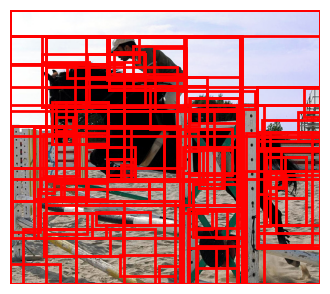

In [50]:
from selectivesearch import selective_search

def get_region_proposals(image):
    img_np = np.array(image)
    _, regions = selective_search(img_np,scale=500, sigma=0.8, min_size=100)

    proposals = []
    for r in regions:
        x, y, w, h = r['rect']
        if (x, y, w, h) in proposals:
            continue

        if w < 20 or h < 20:
            continue
        proposals.append((x, y, w, h))
    return proposals

image, label = subset[0]
regions = get_region_proposals(image)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.axis("off")
ax.imshow(image)
for x, y, w, h in regions:
    rect = plt.Rectangle((x, y), w, h, edgecolor='red', facecolor='none', linewidth=2)
    ax.add_patch(rect)
plt.show()

#### Classifiation
3. Compute CNN Features
4. Classify Regions
5. Sort by Score and pick up top10 resutls

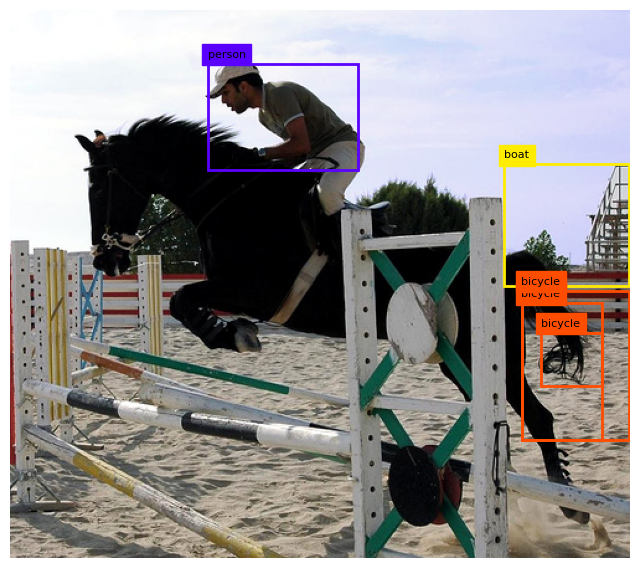

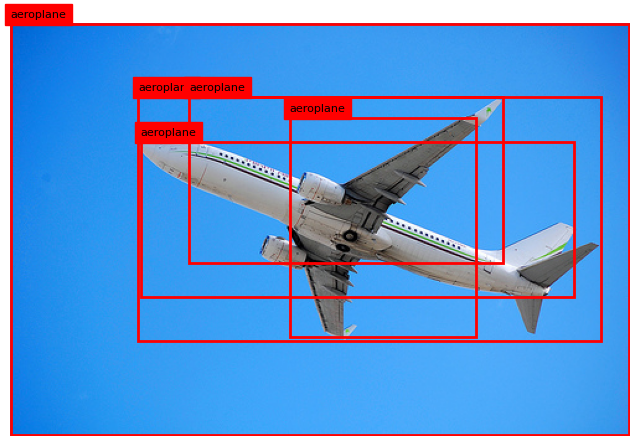

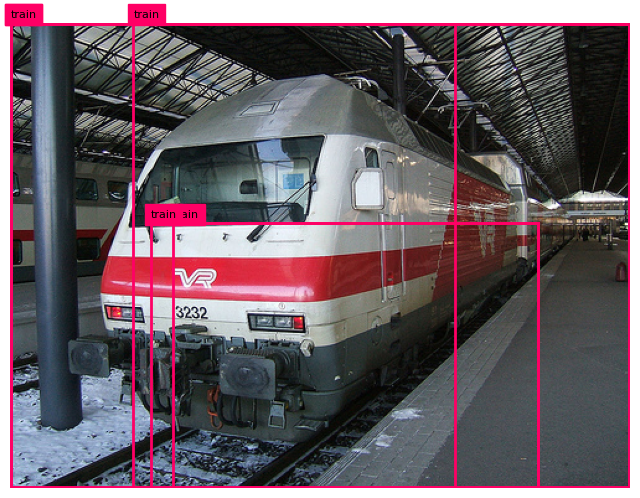

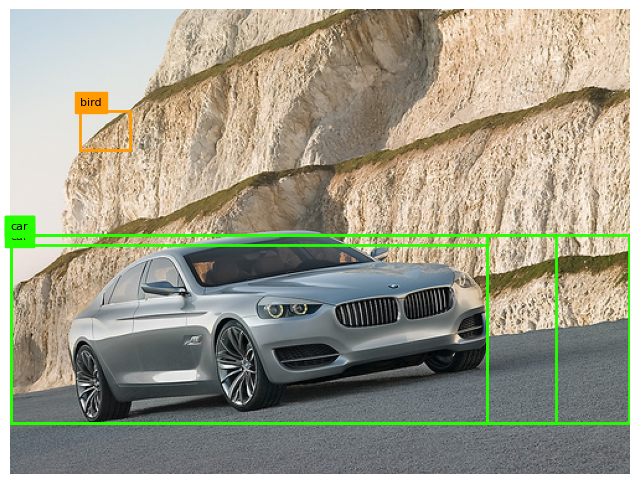

In [51]:
def classify(image, model, device):
    inputs = vgg16_transform(image).unsqueeze(0).to(device)
    outputs = model(inputs)
    score = torch.max(outputs).item()
    prediction = torch.max(outputs, 1)[1].item()
    return score, VOC_CLASSES[prediction]

for image, _ in subset:
    regions = get_region_proposals(image)
    results = []
    for x, y, w, h in regions:
        cropped_image = image.crop((x, y, x+w, y+h))
        score, prediction = classify(cropped_image, vgg16, device)
        results.append((score, prediction, (x, y, w, h)))

    results.sort(reverse=True, key=lambda x: x[0])
    top5 = results[:5]

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.axis("off")
    ax.imshow(image)
    for _, prediciton, bbox in top5:
        draw_annotation(ax, prediciton, bbox)
    plt.show()

## Non-Maximum Suppression (NMS)
1. Sort all predicted bounding boxes by the score.
2. Pick the boxes in order of the score.
3. Calculate the IoU for remained boxes
4. Suppress boxes that have an IoU above a predefined threshold

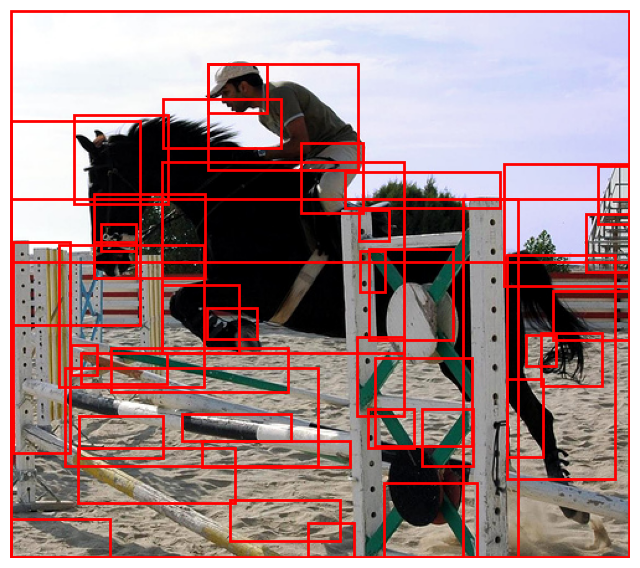

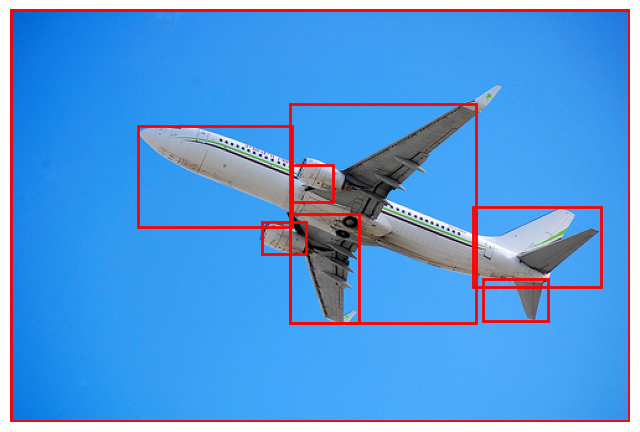

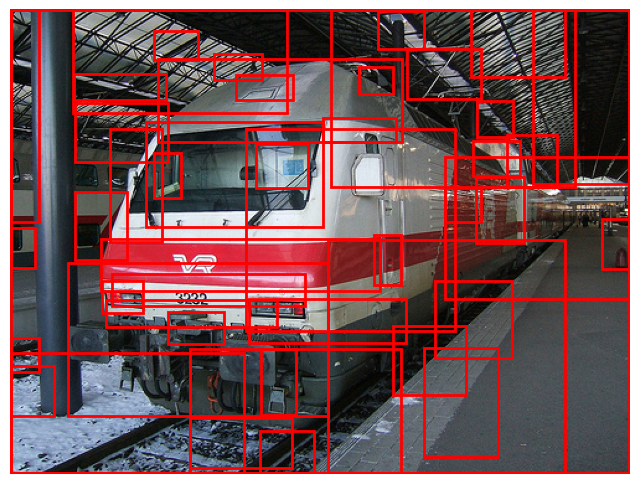

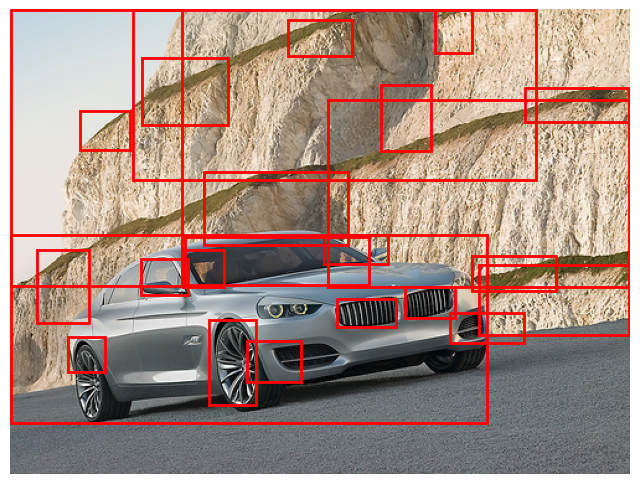

In [52]:
from torchvision import ops

def suppress_boxes(results):
    boxes = torch.tensor([(x, y, x+w, y+h) for _, _, (x, y, w, h) in results], dtype=torch.float32)
    scores = torch.tensor([score for score, _, _ in results], dtype=torch.float32)
    keep_indices = ops.nms(boxes, scores, iou_threshold=0.2)
    return [results[i] for i in keep_indices]


for image, _ in subset:
    regions = get_region_proposals(image)
    results = []

    for x, y, w, h in regions:
        cropped_image = image.crop((x, y, x + w, y + h))
        score, prediction = classify(cropped_image, vgg16, device)
        results.append((score, prediction, (x, y, w, h)))

    results.sort(reverse=True, key=lambda x: x[0])
    results = suppress_boxes(results)

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.axis("off")
    ax.imshow(image)
    for _, _, (x, y, w, h) in results:
        rect = plt.Rectangle((x, y), w, h, edgecolor='red', facecolor='none', linewidth=2)
        ax.add_patch(rect)
    plt.show()

## Model evaluation
#### Basic indicators<br>

$$
\begin{align}
Accuracy &= \frac{TP + TN}{TP + FP + FN + TN} &(= \text{Total Corrections / Total Predictions}) \\
Precision &= \frac{TP}{TP+FP} &(= \text{TP / Total Predicted Positives}) \\
Recall &= \frac{TP}{TP+FN} &(= \text{TP / Total Actual Positives}) \\
F-value &= \frac{2Recall \cdot Precision}{Recall + Precision}&
\end{align}
$$
<br>

#### IoU (Intersectioin of Union):
$$IoU = \frac{Area　of　Overlap}{Area　of　Union}$$
* Metric about the accuracy of object detection models
* It means how well the predicted bounding box matches the ground truth bounding box
* Higer IoU means the model is a good detector
<br>

#### ROC(Receiver Operating Characteristic) Curve / AUC(Area Under the Curve)
* ROC curve: The curve with True Positive rate (y-axis) and False Positive rate (x-axis)
  * True Positive rate (=Recall): TP/ (TP + FN)
  * False Positive rate: FP / (FP + TN)
* AUC: The area of under ROC curve
  * 0.0 < ROC-AUC < 1.0, and higher ROC-AUC means the model is a good predictor


(Example)


| Label  | O  | X  | O  | X  | O  | X  | O  | X  | O  | X  | O  | X  | O  | X  | O  | X  | O  | X  | O  | X  |
|--------|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
| Score  | 0.95 | 0.1 | 0.8 | 0.05 | 0.85 | 0.4 | 0.7 | 0.2 | 0.5 | 0.3 | 0.92 | 0.15 | 0.75 | 0.6 | 0.65 | 0.25 | 0.55 | 0.35 | 0.45 | 0.7 |


* O: Actual is Positive, X: Actual is Negative

In [17]:
LABELS = np.array([True, False, True, False, True, False, True, False, True, False,
                   True, False, True, False, True, False, True, False, True, False,])
SCORES = np.array([0.95, 0.1, 0.8, 0.05, 0.85, 0.4, 0.7, 0.2, 0.5, 0.3,
                   0.92, 0.15, 0.75, 0.6, 0.65, 0.25, 0.55, 0.35, 0.45, 0.7])

def calculate_confusion_matrix(labels, scores, threshold):
    tp = np.sum((scores >= threshold) & labels)
    fp = np.sum((scores >= threshold) & ~labels)
    fn = np.sum((scores < threshold) & labels)
    tn = np.sum((scores < threshold) & ~labels)
    return tp, fp, fn, tn

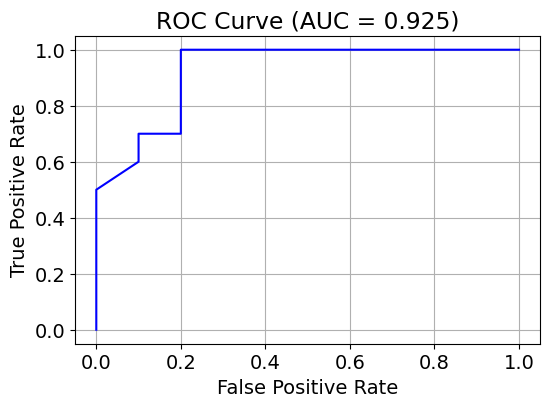

In [18]:
def compute_roc_curve(labels, scores):
    thresholds = np.concatenate(([0], np.unique(scores), [1]))[::-1]
    tpr_values = []
    fpr_values = []
    for threshold in thresholds:
        tp, fp, fn, tn = calculate_confusion_matrix(labels, scores, threshold)
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

        tpr_values.append(tpr)
        fpr_values.append(fpr)

    # Compute the area under the curve using the trapezoidal rule.
    roc_auc = np.trapz(tpr_values, fpr_values)
    return tpr_values, fpr_values, roc_auc

tpr, fpr, roc_auc = compute_roc_curve(LABELS, SCORES)
plt.figure(figsize=(6, 4))
plt.title(f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot(fpr, tpr, color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

#### Average Precision (AP)
Exact average precision: The area under Precision-Recall curve
1. Calculate precision for each threshold and plot the presicion and the recall value
2. Calculate the area using the weighted mean of precisions achieved at each threshold

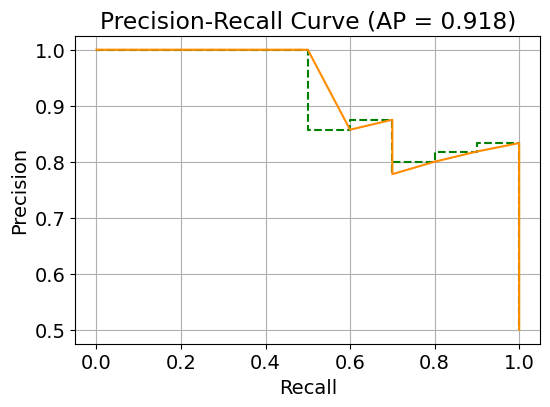

In [19]:
def compute_average_precision(labels, scores):
    thresholds = np.concatenate((np.unique(scores), [1]))[::-1]
    precision_values = []
    recall_values = []
    for threshold in thresholds:
        tp, fp, fn, tn = calculate_confusion_matrix(labels, scores, threshold)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 1
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        precision_values.append(precision)
        recall_values.append(recall)

    ap = 0
    for i in range(len(precision_values) - 1):
        ap += (recall_values[i+1] - recall_values[i]) * precision_values[i+1]
    return precision_values, recall_values, ap

precision, recall, ap = compute_average_precision(LABELS, SCORES)
plt.figure(figsize=(6, 4))
plt.title(f'Precision-Recall Curve (AP = {ap:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')

rect_curve_precision = []
rect_curve_recall = []
for i in range(len(precision)-1):
    rect_curve_precision.append(precision[i])
    rect_curve_recall.append(recall[i])
    rect_curve_precision.append(precision[i+1])
    rect_curve_recall.append(recall[i])

plt.plot(rect_curve_recall, rect_curve_precision,
         color='green', linestyle='--', label='Rectangular approximated PR curve')
plt.plot(recall, precision, color='darkorange')
plt.show()

#### mAP (mean AP)
$$mAP = \frac{1}{C} \sum_{c=1}^{C} AP_c$$

In [20]:
MULTI_CLASS_LABELS = np.array([0, 1, 2, 0, 1, 2, 0, 1, 2, 0])
MULTI_CLASS_SCORES = np.array([
    [0.9, 0.2, 0.3, 0.1, 0.85, 0.75, 0.4, 0.6, 0.1, 0.3],
    [0.1, 0.7, 0.2, 0.9, 0.3, 0.95, 0.8, 0.85, 0.2, 0.7],
    [0.05, 0.1, 0.85, 0.35, 0.9, 0.25, 0.65, 0.2, 0.8, 0.55],
])

In [21]:
n_classes = MULTI_CLASS_SCORES.shape[0]
ap_values = []
for i in range(n_classes):
    labels = (MULTI_CLASS_LABELS == i)
    scores = MULTI_CLASS_SCORES[i, :]

    precision, recall, ap = compute_average_precision(labels, scores)
    ap_values.append(ap)
    print(f"Class {i}: AP = {ap:.3f}")

mAP = np.mean(ap_values)
print(f"Mean Average Precision (mAP): {mAP:.2f}")

Class 0: AP = 0.557
Class 1: AP = 0.365
Class 2: AP = 0.532
Mean Average Precision (mAP): 0.48


#### Simple implementation using scikit-learn

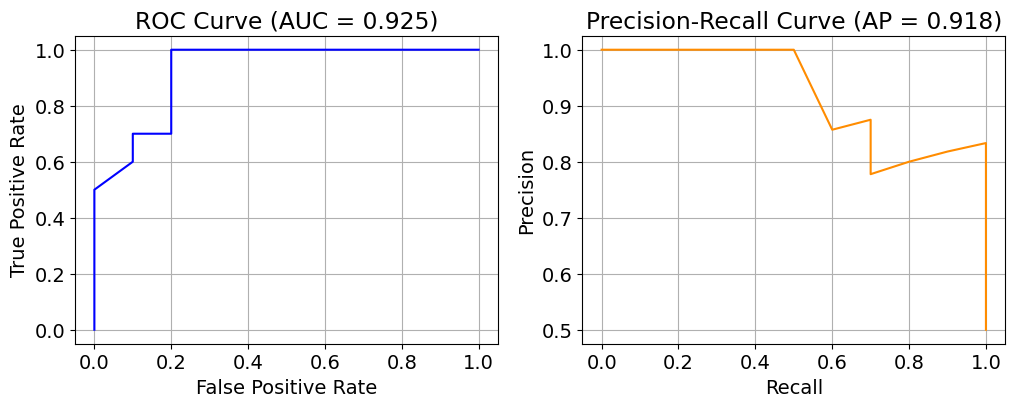

In [22]:
import sklearn.metrics as sk_metrics
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot ROC curve and the AUC.
fpr, tpr, _ = sk_metrics.roc_curve(LABELS, SCORES)
roc_auc = sk_metrics.auc(fpr, tpr)

ax = axes[0]
ax.set_title(f'ROC Curve (AUC = {roc_auc:.3f})')
ax.plot(fpr, tpr, color='blue')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

# Plot Precision-Recall curve and the AP.
precision, recall, _ = sk_metrics.precision_recall_curve(LABELS, SCORES)
ap = sk_metrics.average_precision_score(LABELS, SCORES)

ax = axes[1]
ax.set_title(f'Precision-Recall Curve (AP = {ap:.3f})')
ax.plot(recall, precision, color='darkorange')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
plt.show()

In [23]:
n_classes = MULTI_CLASS_SCORES.shape[0]
ap_values = []
for i in range(n_classes):
    labels = (MULTI_CLASS_LABELS == i)
    scores = MULTI_CLASS_SCORES[i, :]

    precision, recall, _ = sk_metrics.precision_recall_curve(labels, scores)
    ap = sk_metrics.average_precision_score(labels, scores)
    ap_values.append(ap)
    print(f"Class {i}: AP = {ap:.3f}")

mAP = np.mean(ap_values)
print(f"Mean Average Precision (mAP): {mAP:.2f}")

Class 0: AP = 0.557
Class 1: AP = 0.365
Class 2: AP = 0.532
Mean Average Precision (mAP): 0.48


In [24]:
#from google.colab import runtime
#runtime.unassign()